In [1]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %                   SCF-TB - PROXY APPLICATION                      %
# %                   A.M.N. Niklasson, M. Kulichenko. T1, LANL       %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Total Energy Function:                                            %
# % E = 2Tr[H0(D-D0)] + (1/2)*sum_i U_i q_i^2 +                       %
# %      + (1/2)sum_{i,j (i!=j)} q_i C_{ij} q_j - Efield*dipole       %
# % dipole = sum_i R_{i} q_i                                          %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
import torch
import numpy as np
import sys
### path to PYSEQM ###
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")
from seqm.seqm_functions.read_xyz import read_xyz
import scipy.io as sio
import math
import pandas as pd
import importlib
import matplotlib.pyplot as plt


import dftorch
importlib.reload(dftorch)
import dftorch.CoulombMatrix
importlib.reload(dftorch.CoulombMatrix)
from dftorch.CoulombMatrix import CoulombMatrix_vectorized
from dftorch.SCF import SCF

from dftorch.H0andS import H0_and_S_vectorized
from dftorch.Constants import Constants
from dftorch.nearestneighborlist import vectorized_nearestneighborlist
from dftorch.Energy import Energy
from dftorch.Tools import fractional_matrix_power_symm
from dftorch.Forces import Forces

torch.set_default_dtype(torch.float32)
print(torch.cuda.memory_allocated() / 1e9, 'GB')

0.0 GB


In [2]:
%%time

# Initial data, load atoms and coordinates, etc in COORD.dat
device = 'cpu'
const = Constants().to(device)

Efield = 0*0.3*torch.tensor([-.3,0.4,0.0], device=device).T # In arbitrary direction  Works ony in 0-field!!!
Te = 3000.0                       # Some electronic temperature in Kelvin, Possible bug at high tempertures!!!


# species, coordinates = read_xyz(['COORD.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([8,6,6], device=device)

species, coordinates = read_xyz(['C840.xyz'], sort=False) #Input coordinate file
LBox = torch.tensor([36,36,36], device=device)

# species, coordinates = read_xyz(['solvated_1600.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([35,35,35], device=device)

# species, coordinates = read_xyz(['gs_solvated_4k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([100,100,100], device=device)


TYPE = torch.tensor(species[0], dtype=torch.int64, device=device)
RX = torch.tensor(coordinates[0,:,0], device=device).to(torch.get_default_dtype())
RY = torch.tensor(coordinates[0,:,1], device=device).to(torch.get_default_dtype())
RZ = torch.tensor(coordinates[0,:,2], device=device).to(torch.get_default_dtype())
Nocc = int(const.tore[TYPE].sum()/2)

Nats = len(RX)

# Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, but first the neighborlist
#nrnnlist,nndist,nnRx,nnRy,nnRz,nnType,nnStruct,nrnnStruct  = vectorized_nearestneighborlist(RX,RY,RZ,LBox,4.0,Nats);

nrnnlist_no_self, nndist_no_self, nnRx_no_self, nnRy_no_self, nnRz_no_self, nnType_no_self, nnStruct_no_self, nrnnStruct_no_self  = \
        vectorized_nearestneighborlist(RX, RY, RZ, LBox, 4.0, Nats, upper_tri_only=True, remove_self_neigh=False);

H0, dH0, S, dS, D0, H_INDEX_START, H_INDEX_END, Element_Type, Mnuc,Znuc, Hubbard_U, neighbor_I, neighbor_J = H0_and_S_vectorized(TYPE,RX,RY,RZ,LBox,Nats,
                                                                        nrnnlist_no_self,nnRx_no_self,nnRy_no_self,nnRz_no_self,nnType_no_self, const)

HDIM = max(H0.shape)           # Total number of basis functions
#Z = matrix_inverse_sqrt(S)  # Factorization Z of the inverse overlap matrix S. Z is the inverse square root of S
#Z0 = Z  # Z0 is the same as Z
#S0 = S  # Store S as S0

# Parameters for the Coulomb summations
Rcut = 10.42
Coulomb_acc = 10e-7
TIMERATIO = 10

# Get full Coulomb matrix. In principle we do not need an explicit representation of the Coulomb matrix C!
nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct  = vectorized_nearestneighborlist(RX,RY,RZ,LBox,Rcut,Nats,
                                                                                                   upper_tri_only=False, remove_self_neigh=False)
C, dCC = CoulombMatrix_vectorized(RX,RY,RZ,LBox,Hubbard_U,Element_Type,Nats,HDIM,Coulomb_acc,TIMERATIO,nnRx,nnRy,nnRz,nrnnlist,nnType,
                                  H_INDEX_START,H_INDEX_END)


H0_and_S
tensor([   0,    4,    8,   12,   16,   20,   24,   28,   32,   36,   40,   44,
          48,   52,   56,   60,   64,   68,   72,   76,   80,   84,   88,   92,
          96,  100,  104,  108,  112,  116,  120,  124,  128,  132,  136,  140,
         144,  148,  152,  156,  160,  164,  168,  172,  176,  180,  184,  188,
         192,  196,  200,  204,  208,  212,  216,  220,  224,  228,  232,  236,
         240,  244,  248,  252,  256,  260,  264,  268,  272,  276,  280,  284,
         288,  292,  296,  300,  304,  308,  312,  316,  320,  324,  328,  332,
         336,  340,  344,  348,  352,  356,  360,  364,  368,  372,  376,  380,
         384,  388,  392,  396,  400,  404,  408,  412,  416,  420,  424,  428,
         432,  436,  440,  444,  448,  452,  456,  460,  464,  468,  472,  476,
         480,  484,  488,  492,  496,  500,  504,  508,  512,  516,  520,  524,
         528,  532,  536,  540,  544,  548,  552,  556,  560,  564,  568,  572,
         576,  580,  584,  588,

<timed exec>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1730848721463/work/aten/src/ATen/native/TensorShape.cpp:3675.)


  Load S integral params
  Do S Slater-Koster
  t 0.4 s

CoulombMatrix_vectorized
  Do Coulomb Real
  Coulomb_Real t 0.0 s

  Doing Coulomb k
   LMAX: 9
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  Coulomb_k t 1.1 s

CPU times: user 29.4 s, sys: 3.09 s, total: 32.5 s
Wall time: 1.64 s


In [3]:
%%time
torch.set_default_dtype(torch.float64)
# SCF ground state optimization for H and D and q and occupation factors f, D*S*D = D, Tr[DS] = Nocc, f in [0,1]
H,Hcoul,Hdipole,D,q,f = SCF(H0.to(torch.float64), S.to(torch.float64), Efield.to(torch.float64), C.to(torch.float64), 
                            TYPE, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
                            H_INDEX_START, H_INDEX_END,
                            Nocc, Hubbard_U, Znuc, Nats, Te, const, alpha=0.2, acc=1e-9, MAX_ITER=5)
Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0.to(torch.float64), Hubbard_U, Efield, D0, C.to(torch.float64), D, q,
                                         RX, RY, RZ, f, Te) # Energy calculation - 2*Te*S_ent
Etot,Eband0,Ecoul,Edipole,S_ent


### Do SCF ###
  Doing fractional_matrix_power_symm
  Initial DM_Fermi
    eigh     0.8 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s

Starting cycle
Iter 1
  Hcoul 0.0 s
    eigh     0.9 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s
  DM_Fermi 1.3 s
  Z@Dorth@Z.T 0.2 s
  update q 0.0 s
Res = 1.609724851, t = 1.6 s

Iter 2
  Hcoul 0.1 s
    eigh     0.8 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s
  DM_Fermi 1.2 s
  Z@Dorth@Z.T 0.2 s
  update q 0.0 s
Res = 0.249608607, t = 1.5 s

Iter 3
  Hcoul 0.1 s
    eigh     0.8 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s
  DM_Fermi 1.2 s
  Z@Dorth@Z.T 0.2 s
  update q 0.0 s
Res = 0.100385188, t = 1.5 s

Iter 4
  Hcoul 0.1 s
    eigh     0.8 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s
  DM_Fermi 1.2 s
  Z@Dorth@Z.T 0.2 s
  update q 0.0 s
Res = 0.063853531, t = 1.5 s

Iter 5
Did not converge
  Hcoul 0.1 s
    eigh     0.8 s
    dm ptr   0.0 s
    v*p0*v.T 0.1 s
  DM_Fermi 1.2 s
  Z@Dorth@Z.T 0.2 s
  update q 0.0 s
Res = 0.045208075, t = 1.5 s

CPU times: user 3min 30s, sys

(-39404.0940854571,
 -39397.98393173635,
 0.07693171958186243,
 -0.0,
 0.0010311809067218881)

In [4]:
# (-39404.0940854571,
#  -39397.98393173635,
#  0.07693171958186243,
#  -0.0,
#  0.0010311809067218881)

In [8]:
%%time
Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole = Forces(H.to(torch.float64), H0.to(torch.float64),
                                                                S.to(torch.float64), C.to(torch.float64), D.to(torch.float64), D0.to(torch.float64),
                                                                dH0.to(torch.float64), dS.to(torch.float64),
                   dCC.to(torch.float64), Efield, Hubbard_U, q, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
                   Nats, H_INDEX_START, H_INDEX_END, const, TYPE)


Doing Fcoul
Doing Fband0
Doing Pulay
  Doing fractional_matrix_power_symm
Doing Fdipole
Doing FScoul
Doing FSdipole
CPU times: user 51.9 s, sys: 2.66 s, total: 54.6 s
Wall time: 2.73 s


In [4]:
C_Ni_ss = np.array([
 1.570550469210e-01,
 2.080009586422e-01,
 2.595160882079e-01,
 2.988527640661e-01,
 3.206578274014e-01,
 3.239305560270e-01,
 3.100976421435e-01,
 2.817995868213e-01,
 2.421390199744e-01,
 1.942338969743e-01,
 1.409680511498e-01,
 8.486687824051e-02,
 2.805012401795e-02,
-2.776820201294e-02,
-8.125490959796e-02,
-1.314183253843e-01,
-1.775632691102e-01,
-2.192461460782e-01,
-2.562306396349e-01,
-2.884479902866e-01,
-3.159632827475e-01,
-3.389403454141e-01,
-3.576174272517e-01,
-3.722876413937e-01,
-3.832770881311e-01,
-3.909285266140e-01,
-3.955928853822e-01,
-3.976177758963e-01,
-3.973417001119e-01,
-3.950889807352e-01,
-3.911648531517e-01,
-3.858526986805e-01,
-3.794131621213e-01,
-3.720840088557e-01,
-3.640800647933e-01,
-3.555934972864e-01,
-3.467946732461e-01,
-3.378333268390e-01,
-3.288397373712e-01,
-3.199259392854e-01,
-3.111871128817e-01,
-3.027031372920e-01,
-2.945401209503e-01,
-2.867517588523e-01,
-2.793805081506e-01,
-2.724586750846e-01,
-2.660095058797e-01,
-2.600483008006e-01,
-2.545835007018e-01,
-2.496176765697e-01,
-2.451483801500e-01,
-2.411688579924e-01,
-2.376686611872e-01,
-2.346341886970e-01,
-2.320490060932e-01,
-2.298944367313e-01,
-2.281509295588e-01,
-2.267973701172e-01,
-2.258117523333e-01,
-2.251714798905e-01,
-2.248536285317e-01,
-2.248351719073e-01,
-2.250931752627e-01,
-2.256049615448e-01,
-2.263482532471e-01,
-2.273012915819e-01,
-2.284429339263e-01,
-2.297527314817e-01,
-2.312109904995e-01,
-2.327988205987e-01,
-2.344981723323e-01,
-2.362918645072e-01,
-2.381636011852e-01,
-2.400979789119e-01,
-2.420804855604e-01,
-2.440974923787e-01,
-2.461362403862e-01,
-2.481848218517e-01,
-2.502321576741e-01,
-2.522679719077e-01,
-2.542827648624e-01,
-2.562677857933e-01,
-2.582150053511e-01,
-2.601170872373e-01,
-2.619673583269e-01,
-2.637597769599e-01,
-2.654888998236e-01,
-2.671498484102e-01,
-2.687382761711e-01,
-2.702503371788e-01,
-2.716826565778e-01,
-2.730323026270e-01,
-2.742967599027e-01,
-2.754739032988e-01,
-2.765619727219e-01,
-2.775595486807e-01,
-2.784655291506e-01,
-2.792791080775e-01,
-2.799997556898e-01,
-2.806272004955e-01,
-2.811614125833e-01,
-2.816025877146e-01,
-2.819511317228e-01,
-2.822076449049e-01,
-2.823729063312e-01,
-2.824478582086e-01,
-2.824335905737e-01,
-2.823313266100e-01,
-2.821424088143e-01,
-2.818682861079e-01,
-2.815044485138e-01,
-2.810659943097e-01,
-2.805473181468e-01,
-2.799501173299e-01,
-2.792761393700e-01,
-2.785271760571e-01,
-2.777050581922e-01,
-2.768116507905e-01,
-2.758488485850e-01,
-2.748185716931e-01,
-2.737227613387e-01,
-2.725633755590e-01,
-2.713423848620e-01,
-2.700617678287e-01,
-2.687235066838e-01,
-2.673295828804e-01,
-2.658819727599e-01,
-2.643826433543e-01,
-2.628335484007e-01,
-2.612366246312e-01,
-2.595937883902e-01,
-2.579069326178e-01,
-2.561779242247e-01,
-2.544086018672e-01,
-2.526007741218e-01,
-2.507562180461e-01,
-2.488766781045e-01,
-2.469638654321e-01,
-2.450194574018e-01,
-2.430450974583e-01,
-2.410423951772e-01,
-2.390129265083e-01,
-2.369582341579e-01,
-2.348798280694e-01,
-2.327791859608e-01,
-2.306577538829e-01,
-2.285169467652e-01,
-2.263581489225e-01,
-2.241827145011e-01,
-2.219919678490e-01,
-2.197872038029e-01,
-2.175696878871e-01,
-2.153406564300e-01,
-2.131013166044e-01,
-2.108528464058e-01,
-2.085963945845e-01,
-2.063330805487e-01,
-2.040639942581e-01,
-2.017901961268e-01,
-1.995127169529e-01,
-1.972325578888e-01,
-1.949506904649e-01,
-1.926680566761e-01,
-1.903855691350e-01,
-1.881041112969e-01,
-1.858245377537e-01,
-1.835476745964e-01,
-1.812743198418e-01,
-1.790052439167e-01,
-1.767411901950e-01,
-1.744828755796e-01,
-1.722309911221e-01,
-1.699862026719e-01,
-1.677491515480e-01,
-1.655204552239e-01,
-1.633007080192e-01,
-1.610904817895e-01,
-1.588903266076e-01,
-1.567007714286e-01,
-1.545223247349e-01,
-1.523554751542e-01,
-1.502006920474e-01,
-1.480584260648e-01,
-1.459291096670e-01,
-1.438131576115e-01,
-1.417109674060e-01,
-1.396229197276e-01,
-1.375493788134e-01,
-1.354906928215e-01,
-1.334471941691e-01,
-1.314191998475e-01,
-1.294070117202e-01,
-1.274109168051e-01,
-1.254311875447e-01,
-1.234680820672e-01,
-1.215218444406e-01,
-1.195927049222e-01,
-1.176808802054e-01,
-1.157865736656e-01,
-1.139099756063e-01,
-1.120512635077e-01,
-1.102106022770e-01,
-1.083881445029e-01,
-1.065840307140e-01,
-1.047983896419e-01,
-1.030313384879e-01,
-1.012829831959e-01,
-9.955341872796e-02,
-9.784272934460e-02,
-9.615098888815e-02,
-9.447826106864e-02,
-9.282459975120e-02,
-9.119004924448e-02,
-8.957464458875e-02,
-8.797841184292e-02,
-8.640136836957e-02,
-8.484352311698e-02,
-8.330487689747e-02,
-8.178542266126e-02,
-8.028514576523e-02,
-7.880402423604e-02,
-7.734202902717e-02,
-7.590000734853e-02,
-7.447606642628e-02,
-7.307111934751e-02,
-7.168511244346e-02,
-7.031798614053e-02,
-6.896967516429e-02,
-6.764010873765e-02,
-6.632921077360e-02,
-6.503690006265e-02,
-6.376309045512e-02,
-6.250769103860e-02,
-6.127060631087e-02,
-6.005173634845e-02,
-5.885097697116e-02,
-5.766821990286e-02,
-5.650335292872e-02,
-5.535626004910e-02,
-5.422682163051e-02,
-5.311491455370e-02,
-5.202041235898e-02,
-5.094318538924e-02,
-4.988310093048e-02,
-4.884002335019e-02,
-4.781381423360e-02,
-4.680433251783e-02,
-4.581143462411e-02,
-4.483497458800e-02,
-4.387480418764e-02,
-4.293077307009e-02,
-4.200272887566e-02,
-4.109051736036e-02,
-4.019398251617e-02,
-3.931296668944e-02,
-3.844731069703e-02,
-3.759685394038e-02,
-3.676143451744e-02,
-3.594088933228e-02,
-3.513505420242e-02,
-3.434376396395e-02,
-3.356685257414e-02,
-3.280415321178e-02,
-3.205549837507e-02,
-3.132071997702e-02,
-3.059964943850e-02,
-2.989211777869e-02,
-2.919795570325e-02,
-2.851699368980e-02,
-2.784906207110e-02,
-2.719399111577e-02,
-2.655161110649e-02,
-2.592175241586e-02,
-2.530424557993e-02,
-2.469892136921e-02,
-2.410561085756e-02,
-2.352414548861e-02,
-2.295435714010e-02,
-2.239607818586e-02,
-2.184914155571e-02,
-2.131338079323e-02,
-2.078863011141e-02,
-2.027472444624e-02,
-1.977149950839e-02,
-1.927879183284e-02,
-1.879643882660e-02,
-1.832427881461e-02,
-1.786215108377e-02,
-1.740989592516e-02,
-1.696735467459e-02,
-1.653436975127e-02,
-1.611078469497e-02,
-1.569644420146e-02,
-1.529119415633e-02,
-1.489488166724e-02,
-1.450735509468e-02,
-1.412846408119e-02,
-1.375805957903e-02,
-1.339599387655e-02,
-1.304212062303e-02,
-1.269629485213e-02,
-1.235837300409e-02,
-1.202821294647e-02,
-1.170567399362e-02,
-1.139061692494e-02,
-1.108290400179e-02,
-1.078239898324e-02,
-1.048896714054e-02,
-1.020247527054e-02,
-9.922791707806e-03,
-9.649786335734e-03,
-9.383330596476e-03,
-9.123297499835e-03,
-8.869561631077e-03,
-8.621999157741e-03,
-8.380487835417e-03,
-8.144907012568e-03,
-7.915137634360e-03,
-7.691062245620e-03,
-7.472564992815e-03,
-7.259531625195e-03,
-7.051849495095e-03,
-6.849407557339e-03,
-6.652096367903e-03,
-6.459808081757e-03,
-6.272436449971e-03,
-6.089876816047e-03,
-5.912026111595e-03,
-5.738782851290e-03,
-5.570047127162e-03,
-5.405720602285e-03,
-5.245706503791e-03,
-5.089909615396e-03,
-4.938236269212e-03,
-4.790594337144e-03,
-4.646893221742e-03,
-4.507043846477e-03,
-4.370958645624e-03,
-4.238551553658e-03,
-4.109737994248e-03,
-3.984434868762e-03,
-3.862560544471e-03,
-3.744034842326e-03,
-3.628779024404e-03,
-3.516715781043e-03,
-3.407769217602e-03,
-3.301864841002e-03,
-3.198929545947e-03,
-3.098891600903e-03,
-3.001680633829e-03,
-2.907227617720e-03,
-2.815464855875e-03,
-2.726325967034e-03,
-2.639745870351e-03,
-2.555660770129e-03,
-2.474008140515e-03,
-2.394726709966e-03,
-2.317756445670e-03,
-2.243038537855e-03,
-2.170515383953e-03,
-2.100130572751e-03,
-2.031828868450e-03,
-1.965556194668e-03,
-1.901259618403e-03,
-1.838887333992e-03,
-1.778388646972e-03,
-1.719713958014e-03,
-1.662814746811e-03,
-1.607643555983e-03,
-1.554153974999e-03,
-1.502300624105e-03,
-1.452039138336e-03,
-1.403326151481e-03,
-1.356119280176e-03,
-1.310377108013e-03,
-1.266059169712e-03,
-1.223125935364e-03,
-1.181538794746e-03,
-1.141260041704e-03,
-1.102252858663e-03,
-1.064481301163e-03,
-1.027910282516e-03,
-9.925055585706e-04,
-9.582337126113e-04,
-9.250621402797e-04,
-8.929590346810e-04,
-8.618933715878e-04,
-8.318348947694e-04,
-8.027541014071e-04,
-7.746222277357e-04,
-7.474112346696e-04,
-7.210937936979e-04,
-6.956432728543e-04,
-6.710337228407e-04,
-6.472398632986e-04,
-6.242370692291e-04,
-6.020013575509e-04,
-5.805093738677e-04,
-5.597383792890e-04,
-5.396662375144e-04,
-5.202714020295e-04,
-5.015329034733e-04,
-4.834303371806e-04,
-4.659438508879e-04,
-4.490541326123e-04,
-4.327423987071e-04,
-4.169903820799e-04,
-4.017803206322e-04,
-3.870949457891e-04,
-3.729174713050e-04,
-3.592315822110e-04,
-3.460214238865e-04,
-3.332715914413e-04,
-3.209671191434e-04,
-3.090934701133e-04,
-2.976365261767e-04,
-2.865825778915e-04,
-2.759183147631e-04,
-2.656308156631e-04,
-2.557075393537e-04,
-2.461363152641e-04,
-2.369053344155e-04,
-2.280031405145e-04,
-2.194186212227e-04,
-2.111409995973e-04,
-2.031598256964e-04,
-1.954649683364e-04,
-1.880466070760e-04,
-1.808952242343e-04,
-1.740015971860e-04,
-1.673567907548e-04,
-1.609521497670e-04,
-1.547792917495e-04,
-1.488300997831e-04,
-1.430967154887e-04,
-1.375715321577e-04,
-1.322471880202e-04,
-1.271165596398e-04,
-1.221727554786e-04,
-1.174091095165e-04,
-1.128191750750e-04,
-1.083967187295e-04,
-1.041357143527e-04,
-1.000303372690e-04,
-9.607495858127e-05,
-9.226413951141e-05,
-8.848337991922e-05,
-8.494917146377e-05,
-8.154439536545e-05,
-7.826430679598e-05,
-7.510432441438e-05,
-7.206002564532e-05,
-6.912714202334e-05,
-6.630155465164e-05,
-6.357928975677e-05,
-6.095651435400e-05,
-5.842953200647e-05,
-5.599477866479e-05,
-5.364881864154e-05,
-5.138834061455e-05,
-4.921015377130e-05,
-4.711118402659e-05,
-4.508847031936e-05,
-4.313916100942e-05,
-4.126051033890e-05,
-3.944987499496e-05,
-3.770471074954e-05,
-3.602256916131e-05,
-3.440109445616e-05,
-3.283802028992e-05,
-3.133116680345e-05,
-2.987843762281e-05,
-2.847781699976e-05,
-2.712736700325e-05,
-2.582522479282e-05,
-2.456959997862e-05,
-2.335877202079e-05,
-2.219108780421e-05,
-2.106495912029e-05,
-1.997886036632e-05,
-1.893132625614e-05,
-1.792094960646e-05,
-1.694637919281e-05,
-1.600631767354e-05,
-1.509951957940e-05,
-1.422478936978e-05,
-1.338097954037e-05,
-1.256698881330e-05,
-1.178176036757e-05,
-1.102428012976e-05,
-1.029357516014e-05,
-9.588712004825e-06,
-8.908795196823e-06,
-8.252965761308e-06,
-7.620399768657e-06,
-7.010306962475e-06,
-6.421929410042e-06,
-5.854540210959e-06,
-5.307442245321e-06,
-4.779966971568e-06,
-4.271473256216e-06,
-3.781346258936e-06,
-3.308996351770e-06,
-2.853858048553e-06,
-2.415389019497e-06,
-1.993069109079e-06,
-1.586399384428e-06,
-1.194901287607e-06,
-8.181156697799e-07,
-4.556020234643e-07,
-1.069376381693e-07,
 2.282831606676e-07,
 5.504497768208e-07,
 8.599360729179e-07,
 1.157101052585e-06,
 1.442289537522e-06,
 1.715832814116e-06,
 1.978049253909e-06,
 2.229244909254e-06,

])


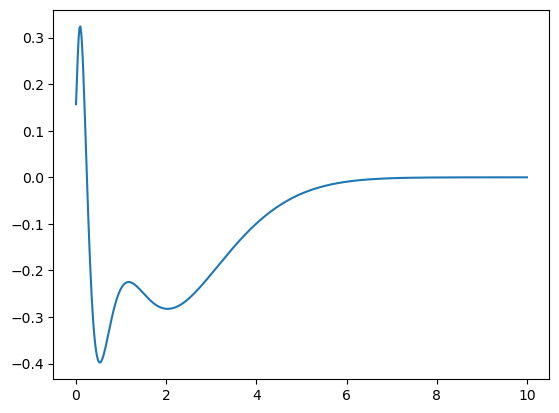

In [6]:
x = np.linspace(0,10,len(C_Ni_ss))
plt.plot(x, C_Ni_ss)

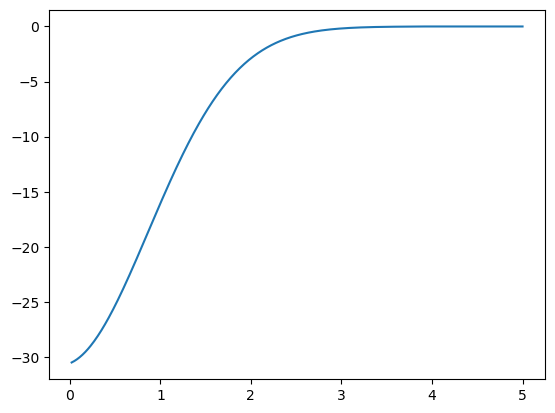

In [42]:
from dftorch.BondIntegral import LoadBondIntegralParameters, bond_integral_vectorized
fss = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,6]), '../src/dftorch/params/fss_sigma.csv')
x = np.linspace(0.02,5,500)
out = bond_integral_vectorized(torch.tensor(x),fss.repeat(500,1))
plt.plot(x, out.cpu())

In [40]:
C_C_ss = np.array([
-1.149953917193e+00,
-1.102295808589e+00,
-1.058190729131e+00,
-1.017500492737e+00,
-9.800728861620e-01,
-9.457485539078e-01,
-9.143610688380e-01,
-8.857392823773e-01,
-8.597141094322e-01,
-8.361194539325e-01,
-8.147896688559e-01,
-7.955607633754e-01,
-7.782738507914e-01,
-7.627769415697e-01,
-7.489251670958e-01,
-7.365806817668e-01,
-7.256121946183e-01,
-7.158941113851e-01,
-7.073061469855e-01,
-6.997340213365e-01,
-6.930707419606e-01,
-6.872137250915e-01,
-6.820856826480e-01,
-6.775935801231e-01,
-6.736575409253e-01,
-6.702037413684e-01,
-6.671643595364e-01,
-6.644773263693e-01,
-6.620858847896e-01,
-6.599380617786e-01,
-6.579861966360e-01,
-6.561866216077e-01,
-6.544994956853e-01,
-6.528887191128e-01,
-6.513218465935e-01,
-6.497699556355e-01,
-6.482074664993e-01,
-6.466119215945e-01,
-6.449637223163e-01,
-6.432458178375e-01,
-6.414433593548e-01,
-6.395433638016e-01,
-6.375344471698e-01,
-6.354066722138e-01,
-6.331515137872e-01,
-6.307619002183e-01,
-6.282322645096e-01,
-6.255585449246e-01,
-6.227381040490e-01,
-6.197695719527e-01,
-6.166526462261e-01,
-6.133878907236e-01,
-6.099765666804e-01,
-6.064205118407e-01,
-6.027220645480e-01,
-5.988840173740e-01,
-5.949095815762e-01,
-5.908023481169e-01,
-5.865662392981e-01,
-5.822054530090e-01,
-5.777244063348e-01,
-5.731276860795e-01,
-5.684200116107e-01,
-5.635988755326e-01,
-5.586826279935e-01,
-5.536710923486e-01,
-5.485694690577e-01,
-5.433829543147e-01,
-5.381167336999e-01,
-5.327759777616e-01,
-5.273658370915e-01,
-5.218914355070e-01,
-5.163578608815e-01,
-5.107701537916e-01,
-5.051332944337e-01,
-4.994521883147e-01,
-4.937316511724e-01,
-4.879763935620e-01,
-4.821910056041e-01,
-4.763799425258e-01,
-4.705475117630e-01,
-4.646978624785e-01,
-4.588349782985e-01,
-4.529626738874e-01,
-4.470845956641e-01,
-4.412042265709e-01,
-4.353248943944e-01,
-4.294497827768e-01,
-4.235819437861e-01,
-4.177243107792e-01,
-4.118797103031e-01,
-4.060508719370e-01,
-4.002404352569e-01,
-3.944509534856e-01,
-3.886848937963e-01,
-3.829446346490e-01,
-3.772324608716e-01,
-3.715505574248e-01,
-3.659010028806e-01,
-3.602857635961e-01,
-3.547066893974e-01,
-3.491655113323e-01,
-3.436638417610e-01,
-3.382031767602e-01,
-3.327849005762e-01,
-3.274102916795e-01,
-3.220805298784e-01,
-3.167967039327e-01,
-3.115598191492e-01,
-3.063708045404e-01,
-3.012305192450e-01,
-2.961397580365e-01,
-2.910992558642e-01,
-2.861096914660e-01,
-2.811716901630e-01,
-2.762858259897e-01,
-2.714526233280e-01,
-2.666725582120e-01,
-2.619460594528e-01,
-2.572735097059e-01,
-2.526552465714e-01,
-2.480915637909e-01,
-2.435827125701e-01,
-2.391289030368e-01,
-2.347303058195e-01,
-2.303870537145e-01,
-2.260992434029e-01,
-2.218669371669e-01,
-2.176901645594e-01,
-2.135689239783e-01,
-2.095031841124e-01,
-2.054928852317e-01,
-2.015379403113e-01,
-1.976382359938e-01,
-1.937936334051e-01,
-1.900039688560e-01,
-1.862690544635e-01,
-1.825886787354e-01,
-1.789626071605e-01,
-1.753905828408e-01,
-1.718723271981e-01,
-1.684075407792e-01,
-1.649959041674e-01,
-1.616370790081e-01,
-1.583307091340e-01,
-1.550764217800e-01,
-1.518738288607e-01,
-1.487244152218e-01,
-1.456232956433e-01,
-1.425726138052e-01,
-1.395719530348e-01,
-1.366208867441e-01,
-1.337189789685e-01,
-1.308657849024e-01,
-1.280608514336e-01,
-1.253037176796e-01,
-1.225939155248e-01,
-1.199309701570e-01,
-1.173144006034e-01,
-1.147437202607e-01,
-1.122184374187e-01,
-1.097380557734e-01,
-1.073020749259e-01,
-1.049099908658e-01,
-1.025612964351e-01,
-1.002554817721e-01,
-9.799203473240e-02,
-9.577044128772e-02,
-9.359018590160e-02,
-9.145075188186e-02,
-8.935162171154e-02,
-8.729227735862e-02,
-8.527220056658e-02,
-8.329087312678e-02,
-8.134777713484e-02,
-7.944239523236e-02,
-7.757421083568e-02,
-7.574270835304e-02,
-7.394737339153e-02,
-7.218769295475e-02,
-7.046315563221e-02,
-6.877325178120e-02,
-6.711747370146e-02,
-6.549531580345e-02,
-6.390627477033e-02,
-6.234984971381e-02,
-6.082554232436e-02,
-5.933285701580e-02,
-5.787130106441e-02,
-5.644038474310e-02,
-5.503962144993e-02,
-5.366852783199e-02,
-5.232662390467e-02,
-5.101343316590e-02,
-4.972848270617e-02,
-4.847130331385e-02,
-4.724142957640e-02,
-4.603839997710e-02,
-4.486175698753e-02,
-4.371104715582e-02,
-4.258582119057e-02,
-4.148563404030e-02,
-4.041004496874e-02,
-3.935861762541e-02,
-3.833092011187e-02,
-3.732652504338e-02,
-3.634500960591e-02,
-3.538595560869e-02,
-3.444894953203e-02,
-3.353358257062e-02,
-3.263945067237e-02,
-3.176615457280e-02,
-3.091329982493e-02,
-3.008049682496e-02,
-2.926736083396e-02,
-2.847351199580e-02,
-2.769857535035e-02,
-2.694218084421e-02,
-2.620396333730e-02,
-2.548356260589e-02,
-2.478062334336e-02,
-2.409479515724e-02,
-2.342573256405e-02,
-2.277309498096e-02,
-2.213654671567e-02,
-2.151575695369e-02,
-2.091039974349e-02,
-2.032015397987e-02,
-1.974470338533e-02,
-1.918373648990e-02,
-1.863694660920e-02,
-1.810403182116e-02,
-1.758469494122e-02,
-1.707864349626e-02,
-1.658558969720e-02,
-1.610525041048e-02,
-1.563734712828e-02,
-1.518160593781e-02,
-1.473775748926e-02,
-1.430553696295e-02,
-1.388468403538e-02,
-1.347494284430e-02,
-1.307606195299e-02,
-1.268779431309e-02,
-1.230989722748e-02,
-1.194213231122e-02,
-1.158426545262e-02,
-1.123606677296e-02,
-1.089731058528e-02,
-1.056777535312e-02,
-1.024724364797e-02,
-9.935502106284e-03,
-9.632341385846e-03,
-9.337556121589e-03,
-9.050944880834e-03,
-8.772310118050e-03,
-8.501458129153e-03,
-8.238199005443e-03,
-7.982346587056e-03,
-7.733718416205e-03,
-7.492135690006e-03,
-7.257423213283e-03,
-7.029409350797e-03,
-6.807925979604e-03,
-6.592808441124e-03,
-6.383895493209e-03,
-6.181029261943e-03,
-5.984055193575e-03,
-5.792822006347e-03,
-5.607181642418e-03,
-5.426989219650e-03,
-5.252102983681e-03,
-5.082384259930e-03,
-4.917697405740e-03,
-4.757909762746e-03,
-4.602891609268e-03,
-4.452516113076e-03,
-4.306659283979e-03,
-4.165199927257e-03,
-4.028019596544e-03,
-3.895002547778e-03,
-3.766035692796e-03,
-3.641008553544e-03,
-3.519813216431e-03,
-3.402344287192e-03,
-3.288498845909e-03,
-3.178176402472e-03,
-3.071278852391e-03,
-2.967710432976e-03,
-2.867377679943e-03,
-2.770189384361e-03,
-2.676056550075e-03,
-2.584892351518e-03,
-2.496612091967e-03,
-2.411133162262e-03,
-2.328374999863e-03,
-2.248259048692e-03,
-2.170708718945e-03,
-2.095649347801e-03,
-2.023008160432e-03,
-1.952714231514e-03,
-1.884698447257e-03,
-1.818893467880e-03,
-1.755233690743e-03,
-1.693655213692e-03,
-1.634095799187e-03,
-1.576494838816e-03,
-1.520793318323e-03,
-1.466933783179e-03,
-1.414860304686e-03,
-1.364518446457e-03,
-1.315855231615e-03,
-1.268819110320e-03,
-1.223359927915e-03,
-1.179428893662e-03,
-1.137037165059e-03,
-1.096039286322e-03,
-1.056430477035e-03,
-1.018167046152e-03,
-9.812065207714e-04,
-9.455076179416e-04,
-9.110302169980e-04,
-8.777353324590e-04,
-8.455850871908e-04,
-8.145426862326e-04,
-7.845723909818e-04,
-7.556394938303e-04,
-7.277102933553e-04,
-7.007520697259e-04,
-6.747330608496e-04,
-6.496224386925e-04,
-6.253902861604e-04,
-6.020075742881e-04,
-5.794461402171e-04,
-5.576786650291e-04,
-5.366786524018e-04,
-5.164204075868e-04,
-4.968790165255e-04,
-4.780303259213e-04,
-4.598509231779e-04,
-4.423181170260e-04,
-4.254099183150e-04,
-4.091050214276e-04,
-3.933827859343e-04,
-3.782232186456e-04,
-3.636069560892e-04,
-3.495152472887e-04,
-3.359299368294e-04,
-3.228334485747e-04,
-3.102087695243e-04,
-2.980394339167e-04,
-2.863095079684e-04,
-2.750035747487e-04,
-2.641067194936e-04,
-2.536045152234e-04,
-2.434830086804e-04,
-2.337287067114e-04,
-2.243285627460e-04,
-2.152699638270e-04,
-2.065407178410e-04,
-1.981290410851e-04,
-1.900235461676e-04,
-1.822132301342e-04,
-1.746874630046e-04,
-1.674359764941e-04,
-1.604488530837e-04,
-1.537165154087e-04,
-1.472297157957e-04,
-1.409795262061e-04,
-1.349573284030e-04,
-1.291548043263e-04,
-1.235639266980e-04,
-1.181769502064e-04,
-1.129864023817e-04,
-1.079850752335e-04,
-1.031660167113e-04,
-9.852252268839e-05,
-9.404812908465e-05,
-8.973660395908e-05,
-8.558194041387e-05,
-8.157834902919e-05,
-7.772025091877e-05,
-7.400227085270e-05,
-7.041923058906e-05,
-6.696614239388e-05,
-6.363820274461e-05,
-6.043078620115e-05,
-5.733943947274e-05,
-5.435987571966e-05,
-5.148796877637e-05,
-4.871974786365e-05,
-4.605139215851e-05,
-4.347922581950e-05,
-4.099971289282e-05,
-3.860945249305e-05,
-3.630517413226e-05,
-3.408373311938e-05,
-3.194210616331e-05,
-2.987738707289e-05,
-2.788678259204e-05,
-2.596760833073e-05,
-2.411728496405e-05,
-2.233333425540e-05,
-2.061337549979e-05,
-1.895512190944e-05,
-1.735637716398e-05,
-1.581503204288e-05,
-1.432906122493e-05,
-1.289652007283e-05,
-1.151554161428e-05,
-1.018433367430e-05,
-8.901175825334e-06,
-7.664416872616e-06,
-6.472471898334e-06,
-5.323819963025e-06,
-4.217001421471e-06,
-3.150615577522e-06,
-2.123318303020e-06,
-1.133819818391e-06,
-1.808824883010e-07,
 7.366812741810e-07,
 1.620010999257e-06,
 2.470200316571e-06,
 3.288298531268e-06,
 4.075312712228e-06,
 4.832209383700e-06,
 5.559916104107e-06,
 6.259323320632e-06,
 6.931285800685e-06,
 7.576624204782e-06,
 8.196126542361e-06,
 8.790549552273e-06,
 9.360620135140e-06,
 9.907036601091e-06,
 1.043046994910e-05,
 1.093156508319e-05,
 1.141094196394e-05,
 1.186919672349e-05,
 1.230690279964e-05,
 1.272461188059e-05,
 1.312285493432e-05,
 1.350214319065e-05,
 1.386296902554e-05,
 1.420580688393e-05,
 1.453111397448e-05,
 1.483933129886e-05,
 1.513088427880e-05,
 1.540618353524e-05,
 1.566562559940e-05,
 1.590959359382e-05,
 1.613845788686e-05,
 1.635257670647e-05,
 1.655229673293e-05,
 1.673795373816e-05,
 1.690987301503e-05,
 1.706836993786e-05,
 1.721375060123e-05,
 1.734631205347e-05,
 1.746634293391e-05,
 1.757412380075e-05,
 1.766992757539e-05,
 1.775401999580e-05,
 1.782665992018e-05,
 1.788809969526e-05,
 1.793858550254e-05,
 1.797835767781e-05,
 1.800765097758e-05,
 1.802669502460e-05,
 1.803571434789e-05,
 1.803492880015e-05,
 1.802455376480e-05,
 1.800480038913e-05,
 1.797587581191e-05,
 1.793798334239e-05,
 1.789132270075e-05,
 1.783609017331e-05,
 1.777247879418e-05,
 1.770067850903e-05,
 1.762087632884e-05,
 1.753325647851e-05,
 1.743800051411e-05,
 1.733528747609e-05,
 1.722529403231e-05,
 1.710819441308e-05,
 1.698416080043e-05,
 1.685336320822e-05,
 1.671596963469e-05,
 1.657214616634e-05,
 1.642205701289e-05,
 1.626586458692e-05,
 1.610372959102e-05,
 1.593581105488e-05,
 1.576226638624e-05,
 1.558325144942e-05,
 1.539892054641e-05,
 1.520942655687e-05,
 1.501492086016e-05,
 1.481555343772e-05,
 1.461147284815e-05,
 1.440282639610e-05,
])


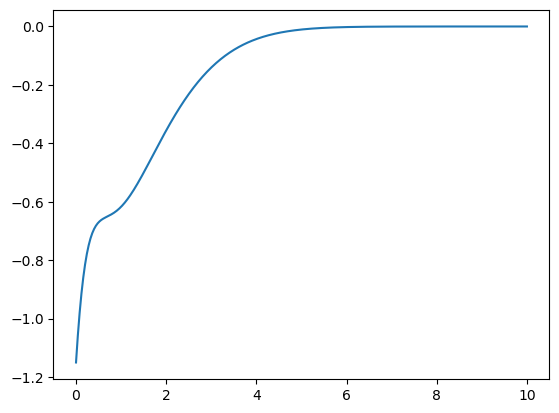

In [41]:
x = np.linspace(0,10,len(C_C_ss))
plt.plot(x, C_C_ss)